# Import libraries

In [3]:
import numpy as np
import pandas as pd
import os

# Read data

In [4]:
DATASET_PATH = '../../data/processed'
DATASET_CSV_PATH = f'{DATASET_PATH}/CSV'

In [5]:
LABEL = {
    'Jump': 0,
    'Kick': 1,
    'Punch': 2,
    'Left': 3,
    'Right': 4,
    'Stand': 5
}

In [6]:
X = []
y = []

# Read all files in the dataset
for label in LABEL:
    for file in os.listdir(f'{DATASET_CSV_PATH}/Test/{label}'):
        df = pd.read_csv(f'{DATASET_CSV_PATH}/Test/{label}/{file}', sep=',')
        X.append(df)
        y.append(LABEL[label])
        print(f"Read file: {file}")

Read file: resized_Jump_10.csv
Read file: resized_Jump_11.csv
Read file: resized_Jump_12.csv
Read file: resized_Jump_13.csv
Read file: resized_Jump_14.csv
Read file: resized_Jump_15.csv
Read file: resized_Jump_16.csv
Read file: resized_Jump_18.csv
Read file: resized_Jump_20.csv
Read file: resized_Jump_21.csv
Read file: resized_Jump_22.csv
Read file: resized_Jump_23.csv
Read file: resized_Jump_5.csv
Read file: resized_Jump_9.csv
Read file: resized_Kick_10.csv
Read file: resized_Kick_12.csv
Read file: resized_Kick_13.csv
Read file: resized_Kick_14.csv
Read file: resized_Kick_15.csv
Read file: resized_Kick_16.csv
Read file: resized_Kick_17.csv
Read file: resized_Kick_18.csv
Read file: resized_Kick_19.csv
Read file: resized_Kick_2.csv
Read file: resized_Kick_20.csv
Read file: resized_Kick_21.csv
Read file: resized_Kick_22.csv
Read file: resized_Kick_23.csv
Read file: resized_Kick_24.csv
Read file: resized_Kick_25.csv
Read file: resized_Kick_6.csv
Read file: resized_Kick_8.csv
Read file: re

In [7]:
# Drop first and second columns
for i, element in enumerate(X):
    X[i] = element.drop(element.columns[[0, 1]], axis=1)

In [8]:
for i, element in enumerate(X):
    for column in element.columns:
        X[i][column] = X[i][column].apply(lambda x: np.array(x[1:-1].split(',')).astype(np.float32))

## Convert All Sequences to the Same Length

In [9]:
# Get the maximum length of all sequences
all_dim = []
for i, element in enumerate(X):
    all_dim.append(element.shape[0])
    print(f"Element {i} shape: {np.shape(element)}, label: {y[i]}")

Element 0 shape: (69, 33), label: 0
Element 1 shape: (64, 33), label: 0
Element 2 shape: (57, 33), label: 0
Element 3 shape: (84, 33), label: 0
Element 4 shape: (60, 33), label: 0
Element 5 shape: (63, 33), label: 0
Element 6 shape: (60, 33), label: 0
Element 7 shape: (62, 33), label: 0
Element 8 shape: (31, 33), label: 0
Element 9 shape: (81, 33), label: 0
Element 10 shape: (31, 33), label: 0
Element 11 shape: (31, 33), label: 0
Element 12 shape: (64, 33), label: 0
Element 13 shape: (44, 33), label: 0
Element 14 shape: (31, 33), label: 1
Element 15 shape: (31, 33), label: 1
Element 16 shape: (31, 33), label: 1
Element 17 shape: (31, 33), label: 1
Element 18 shape: (45, 33), label: 1
Element 19 shape: (43, 33), label: 1
Element 20 shape: (48, 33), label: 1
Element 21 shape: (39, 33), label: 1
Element 22 shape: (39, 33), label: 1
Element 23 shape: (21, 33), label: 1
Element 24 shape: (46, 33), label: 1
Element 25 shape: (43, 33), label: 1
Element 26 shape: (24, 33), label: 1
Element 27 

### Handle the Outliers and make the lengths of all sequences the same
Handle different lengths of sequences
    Set the maximum length = 1.5 * IQR + Q3
    
    * Case 1: If e_dim < Max_dim, then increase the length of the sequence by duplicating each row until the length of the sequence is equal to Max_dim
    * Case 2: If e_dim > Max_dim, then truncate randomly the sequence until the length of the sequence is equal to Max_dim
    * Case 3: If e_dim = Max_dim, then keep the sequence as it is

In [10]:
Max_dim = 35

In [11]:
X_train_temp = []
Y_train_temp = []

def pad_length(ele, max_dim, metric_temp:list=None) -> np.array:
    if metric_temp is None:
        metric_temp = []
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)
    
    step = max(1, ele.shape[0] // (max_dim - ele.shape[0]))

    for j in range(0, ele.shape[0]):
        metric_temp.append(ele.iloc[j])
        if len(metric_temp) == max_dim:
            break
        if j % step == 0:
            metric_temp.append(ele.iloc[j])
        if len(metric_temp) == max_dim:
            break
    return pad_length(pd.DataFrame(metric_temp), max_dim)

def truncate_length(ele, max_dim, start=0) -> np.array:
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)
    
    metrics_temp:list = []
    step = max(2, ele.shape[0] // (ele.shape[0] - max_dim))
    j = start
    while len(metrics_temp) != max_dim:
        metrics_temp.append(ele.iloc[j])
        j = (j + step) % ele.shape[0]
    return pd.DataFrame(metrics_temp)

def pad_and_truncate(ele, max_dim: int=35) -> np.array:
    list_elements:list = []
    current_length = ele.shape[0]
    
    if current_length == max_dim:
        return [ele]
    
    dev = max(int(round(current_length / max_dim)), 1)
    if dev * max_dim > current_length:
        new_element = pad_length(ele, max_dim * dev)
            
        if new_element.shape[0] > max_dim:
            for step in range(dev):
                list_elements.append(truncate_length(new_element, max_dim, step))
        else:
            list_elements.append(new_element)
    else:
        for step in range(dev):
            list_elements.append(truncate_length(ele, max_dim, step))
    return list_elements
# Pad all sequences to the same length
for i, element in enumerate(X):
    print(f"Before padding, element {i} shape: {np.shape(element)}")
    padded_element = pad_and_truncate(element, Max_dim)
    print(f"After padding, element {i} shape: {np.shape(padded_element)}")
    X_train_temp = X_train_temp + padded_element
    Y_train_temp = Y_train_temp + [y[i]] * len(padded_element)
    print(f"After padding X_train_temp, element {i} shape: {np.shape(X_train_temp)}")
    print(f"After padding Y_train_temp, element {i} shape: {np.shape(Y_train_temp)}")
    print('-----------------------------------')
# test = X[15]
# padded_element = pad_and_truncate(test, Max_dim)
# np.array(padded_element).shape

Before padding, element 0 shape: (69, 33)
After padding, element 0 shape: (2, 35, 33)
After padding X_train_temp, element 0 shape: (2, 35, 33)
After padding Y_train_temp, element 0 shape: (2,)
-----------------------------------
Before padding, element 1 shape: (64, 33)
After padding, element 1 shape: (2, 35, 33)
After padding X_train_temp, element 1 shape: (4, 35, 33)
After padding Y_train_temp, element 1 shape: (4,)
-----------------------------------
Before padding, element 2 shape: (57, 33)
After padding, element 2 shape: (2, 35, 33)
After padding X_train_temp, element 2 shape: (6, 35, 33)
After padding Y_train_temp, element 2 shape: (6,)
-----------------------------------
Before padding, element 3 shape: (84, 33)
After padding, element 3 shape: (2, 35, 33)
After padding X_train_temp, element 3 shape: (8, 35, 33)
After padding Y_train_temp, element 3 shape: (8,)
-----------------------------------
Before padding, element 4 shape: (60, 33)
After padding, element 4 shape: (2, 35, 33

In [12]:
X_train_ = np.array(X_train_temp)

In [13]:
X_test = np.full((X_train_.shape[0], X_train_.shape[1], X_train_.shape[2], 3), np.nan, dtype=np.float32)

for i, element in enumerate(X_train_):
    for j, row in enumerate(element):
        for k, value in enumerate(row):
            # Check if the value is np.array([nan, nan, nan])
            if np.isnan(value).all():
                X_train_[i][j][k] = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
            else:
                X_train_[i][j][k] = value
                
            X_test[i][j][k] = X_train_[i][j][k][:3]

## Handle Fill NaN Values

### Step 1: Compute the variance of each metric for each sequence.

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


### Step 1: Compute the variance of each metric for each sequence.

In [14]:
variance_metric = np.empty((X_test.shape[0], X_test.shape[2], 3), dtype=np.float32)
variance_metric.shape

(140, 33, 3)

In [15]:
cls_nan = dict()

for i, element in enumerate(X_test):
    sub_variance_metric = np.empty((element.shape[1], 3), dtype=np.float32)
    
    for j in range(element.shape[1]):
        variance = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
        
        # If there are more than 1 non-NaN values, calculate variance
        if np.count_nonzero(~np.isnan(element[:, j])) > 1:
            variance = np.nanvar(element[:, j], axis=0)
            print(variance)
        else:
            if i not in cls_nan:
                cls_nan[i] = []
            cls_nan[i].append(j)
        # convert to list
        sub_variance_metric[j] = variance
    # print(sub_variance_metric)
    variance_metric[i] = sub_variance_metric

[9.0083020e-05 3.5123671e-03 2.7122486e-02]
[0.00015902 0.00344272 0.02598564]
[0.00020923 0.0034635  0.02598655]
[0.00028354 0.00348239 0.02600165]
[0.00010876 0.00338788 0.02584656]
[0.00014198 0.00340747 0.02586343]
[0.00019237 0.0034433  0.02586255]
[0.00046246 0.00368267 0.02267768]
[0.00034011 0.00375338 0.02115793]
[0.00012828 0.00362189 0.02315703]
[6.9406546e-05 3.5144549e-03 2.3329753e-02]
[0.00231796 0.00452739 0.01454112]
[0.00197203 0.00466768 0.01169195]
[0.00470983 0.00484541 0.02300217]
[0.00521017 0.00548131 0.01889805]
[0.00630808 0.00446382 0.06113362]
[0.00626533 0.00452244 0.07075725]
[0.00737688 0.00449597 0.07389346]
[0.00719432 0.00467196 0.08615217]
[0.00653842 0.00423913 0.07459047]
[0.00624534 0.00442717 0.08557723]
[0.006063   0.00425916 0.06297944]
[0.0057177  0.00436583 0.07293981]
[0.00056109 0.00416523 0.00011862]
[0.00053918 0.00416155 0.0001177 ]
[0.00083605 0.00338539 0.04881798]
[0.00083974 0.00302161 0.04952037]
[0.00069905 0.00179459 0.03451746]
[0

In [16]:
variance_metric = np.array([variance_metric], dtype=np.float32)

In [17]:
variance_metric = variance_metric.reshape(variance_metric.shape[1], variance_metric.shape[2], variance_metric.shape[3])

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


In [18]:
# Function to fill NaN values based on the described cases
def fill_nan(element, variance_metric):
    old_value = None
    k = 0
    
    for i in range(element.shape[0]):
        if np.isnan(element[i]).all():
            # Case 1: If element[i] doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
            if old_value is None:
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        element[i] = element[l] + abs(i - l) * variance_metric
                        break
            else:
                # Case 2: If element[i] doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
                flat = False
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        if l != k:
                            element[i] = old_value + (element[l] - old_value) / ((i - k) / (l - k))
                            flat = True
                            break
                if not flat:
                    # Case 3: If element[i] has values both before and after, then use the nearest previous and posterior elements
                    element[i] = old_value - abs(i - k) * variance_metric
        old_value = element[i]
    return element

In [19]:
X_test_new = np.empty(X_test.shape, dtype=np.float32)
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[2]):
        # print("Shape of element: ", X_train[i][: , j].shape)
        # print("Shape of variance: ", variance_metric[i][j].shape)
        X_test_new[i][: , j] = fill_nan(X_test[i][: , j], variance_metric[i][j])

In [20]:
np.isnan(np.array([np.nan, np.nan, 0])).sum()

2

In [21]:
variance_metric[0][2]

array([0.00020923, 0.0034635 , 0.02598655], dtype=float32)

In [24]:
# Drop data with NaN values
drop_index = list(cls_nan.keys())
# Drop data in X_train_new that has index in drop_index
X_train_new = np.delete(X_test_new, drop_index, axis=0)
y_train = np.delete(X_test_new, drop_index, axis=0)

## LSTM model LSTM model

In [25]:
from tensorflow import keras

In [26]:
# Reshape the data
X_test_reshaped = X_test_new.reshape(X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2] * X_test_new.shape[3])

In [27]:
# load the model
model = keras.models.load_model('model.h5')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 35, 99], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Text(0.5, 80.7222222222222, 'Predicted')

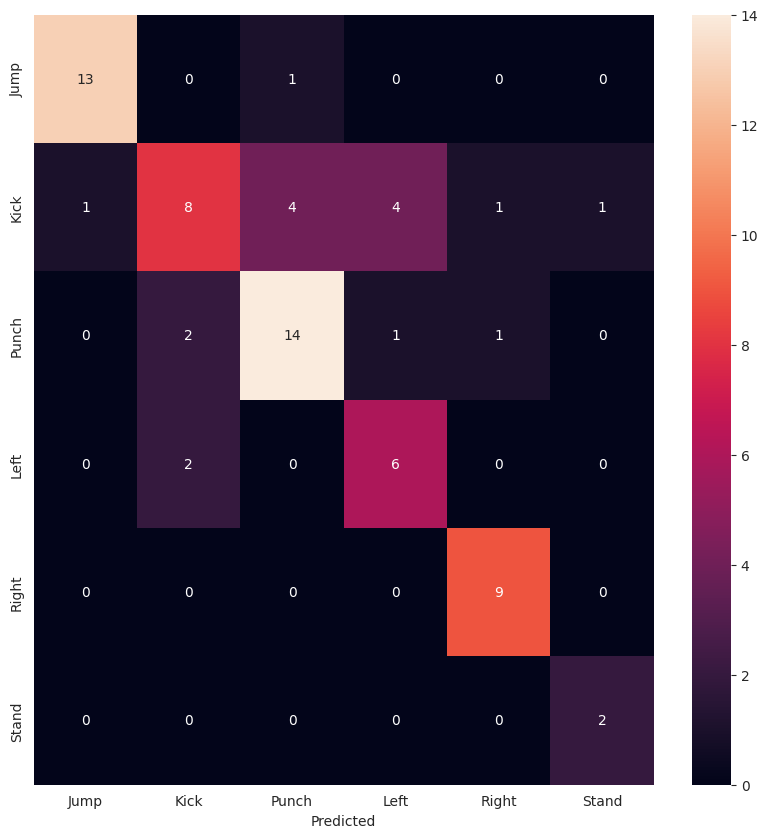

In [48]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(Y_train_temp)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=LABEL.keys(), yticklabels=LABEL.keys())
plt.xlabel('Predicted')

In [63]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

In [50]:
# Show the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=LABEL.keys()))

              precision    recall  f1-score   support

        Jump       0.93      0.93      0.93        14
        Kick       0.67      0.42      0.52        19
       Punch       0.74      0.78      0.76        18
        Left       0.55      0.75      0.63         8
       Right       0.82      1.00      0.90         9
       Stand       0.67      1.00      0.80         2

    accuracy                           0.74        70
   macro avg       0.73      0.81      0.76        70
weighted avg       0.74      0.74      0.73        70
